# EXPLORATION 22. 폐렴아 기다려라!

## Import

In [1]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Setting

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 40

## Dataset

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### Preprocess

In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1063
Pneumonia images count in training set: 3122


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_basic = prepare_for_training(train_ds)
val_ds_basic = prepare_for_training(val_ds)

### Augmentation

In [15]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_aug_ds = prepare_for_training_aug(train_ds)
val_aug_ds = prepare_for_training_aug(val_ds)

### Visualization

#### basic

(16, 180, 180, 3)
(16,)


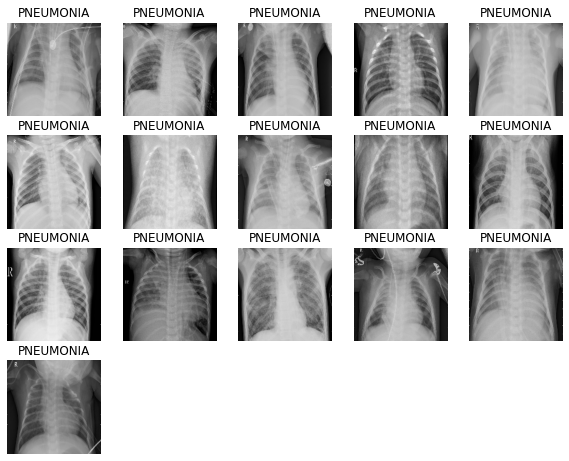

In [16]:
image_batch, label_batch = next(iter(train_ds_basic))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    print(image_batch.shape)
    print(label_batch.shape)
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

#### aug

(16, 180, 180, 3)
(16,)


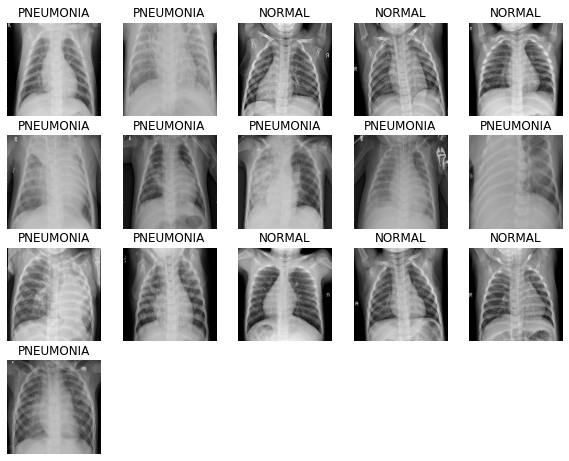

In [17]:
image_aug_batch, label_aug_batch = next(iter(train_aug_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    print(image_batch.shape)
    print(label_batch.shape)
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_aug_batch.numpy(), label_aug_batch.numpy())

## Model

In [18]:
def conv_block(layer, filters):
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(layer)
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    return x

In [19]:
def dense_block(layer, units, dropout_rate=0.5, dropout=True):
    x = tf.keras.layers.Dense(units, activation='relu')(layer)
    x = tf.keras.layers.BatchNormalization()(x)
    if dropout:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    return x

In [20]:
def build_model(dropout=True):
    input_layer = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    
    x = conv_block(x, 128)
    if dropout:
        x = tf.keras.layers.Dropout(0.2)(x)
    
    x = conv_block(x, 256)
    if dropout:
        x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = dense_block(x, 512, 0.7)
    x = dense_block(x, 128, 0.5)
    x = dense_block(x, 64, 0.3)
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    
    return model

### Imbalance

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.97
Weight for class 1: 0.67


### Train

#### basic

In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
261/261 [==============================] - 24s 93ms/step - loss: 0.4086 - accuracy: 0.8008 - precision: 0.9507 - recall: 0.7730 - val_loss: 0.7993 - val_accuracy: 0.7269 - val_precision: 0.7269 - val_recall: 1.0000
Epoch 2/40
261/261 [==============================] - 23s 90ms/step - loss: 0.2369 - accuracy: 0.9080 - precision: 0.9740 - recall: 0.9008 - val_loss: 1.3610 - val_accuracy: 0.7269 - val_precision: 0.7269 - val_recall: 1.0000
Epoch 3/40
261/261 [==============================] - 24s 90ms/step - loss: 0.2019 - accuracy: 0.9234 - precision: 0.9739 - recall: 0.9220 - val_loss: 0.4672 - val_accuracy: 0.7865 - val_precision: 0.7735 - val_recall: 1.0000
Epoch 4/40
261/261 [==============================] - 23s 89ms/step - loss: 0.1722 - accuracy: 0.9375 - precision: 0.9804 - recall: 0.9347 - val_loss: 0.0904 - val_accuracy: 0.9615 - val_precision: 0.9799 - val_recall: 0.9670
Epoch 5/40
261/261 [==============================] - 23s 89ms/step - loss: 0.1644 - accuracy: 0

261/261 [==============================] - 25s 94ms/step - loss: 0.0591 - accuracy: 0.9782 - precision: 0.9938 - recall: 0.9769 - val_loss: 0.1260 - val_accuracy: 0.9490 - val_precision: 0.9972 - val_recall: 0.9326
Epoch 38/40
261/261 [==============================] - 24s 92ms/step - loss: 0.0445 - accuracy: 0.9837 - precision: 0.9967 - recall: 0.9814 - val_loss: 0.0625 - val_accuracy: 0.9760 - val_precision: 0.9867 - val_recall: 0.9801
Epoch 39/40
261/261 [==============================] - 24s 93ms/step - loss: 0.0432 - accuracy: 0.9868 - precision: 0.9971 - recall: 0.9852 - val_loss: 0.0957 - val_accuracy: 0.9683 - val_precision: 0.9664 - val_recall: 0.9907
Epoch 40/40
261/261 [==============================] - 24s 93ms/step - loss: 0.0342 - accuracy: 0.9871 - precision: 0.9971 - recall: 0.9856 - val_loss: 0.0598 - val_accuracy: 0.9798 - val_precision: 0.9946 - val_recall: 0.9775


#### basic + augmentation

In [24]:
with tf.device('/GPU:0'):
    model_aug = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_aug.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [25]:
with tf.device('/GPU:0'):
    history_aug = model_aug.fit(
        train_aug_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_aug_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
261/261 [==============================] - 24s 93ms/step - loss: 0.4210 - accuracy: 0.7929 - precision: 0.9457 - recall: 0.7664 - val_loss: 0.5977 - val_accuracy: 0.7260 - val_precision: 0.7260 - val_recall: 1.0000
Epoch 2/40
261/261 [==============================] - 24s 91ms/step - loss: 0.2486 - accuracy: 0.9009 - precision: 0.9704 - recall: 0.8943 - val_loss: 1.3047 - val_accuracy: 0.7250 - val_precision: 0.7250 - val_recall: 1.0000
Epoch 3/40
261/261 [==============================] - 23s 88ms/step - loss: 0.2199 - accuracy: 0.9162 - precision: 0.9733 - recall: 0.9126 - val_loss: 0.4093 - val_accuracy: 0.7798 - val_precision: 0.7675 - val_recall: 1.0000
Epoch 4/40
261/261 [==============================] - 23s 89ms/step - loss: 0.1865 - accuracy: 0.9310 - precision: 0.9787 - recall: 0.9278 - val_loss: 0.1985 - val_accuracy: 0.9173 - val_precision: 0.8988 - val_recall: 0.9987
Epoch 5/40
261/261 [==============================] - 23s 90ms/step - loss: 0.1738 - accuracy: 0

Epoch 36/40
261/261 [==============================] - 23s 89ms/step - loss: 0.0387 - accuracy: 0.9844 - precision: 0.9961 - recall: 0.9830 - val_loss: 0.1097 - val_accuracy: 0.9788 - val_precision: 0.9959 - val_recall: 0.9748
Epoch 37/40
261/261 [==============================] - 23s 90ms/step - loss: 0.0857 - accuracy: 0.9703 - precision: 0.9915 - recall: 0.9687 - val_loss: 0.0650 - val_accuracy: 0.9769 - val_precision: 0.9946 - val_recall: 0.9735
Epoch 38/40
261/261 [==============================] - 23s 88ms/step - loss: 0.0709 - accuracy: 0.9727 - precision: 0.9934 - recall: 0.9696 - val_loss: 0.0567 - val_accuracy: 0.9760 - val_precision: 0.9946 - val_recall: 0.9722
Epoch 39/40
261/261 [==============================] - 23s 90ms/step - loss: 0.0565 - accuracy: 0.9794 - precision: 0.9970 - recall: 0.9753 - val_loss: 0.0536 - val_accuracy: 0.9798 - val_precision: 1.0000 - val_recall: 0.9722
Epoch 40/40
261/261 [==============================] - 23s 88ms/step - loss: 0.0494 - accura

#### no dropout

In [26]:
 with tf.device('/GPU:0'):
    model_no_drop = build_model(dropout=False)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_no_drop.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [27]:
with tf.device('/GPU:0'):
    history_no_drop = model_no_drop.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/40
261/261 [==============================] - 24s 93ms/step - loss: 0.3546 - accuracy: 0.8386 - precision: 0.9604 - recall: 0.8175 - val_loss: 0.6586 - val_accuracy: 0.7279 - val_precision: 0.7279 - val_recall: 1.0000
Epoch 2/40
261/261 [==============================] - 24s 91ms/step - loss: 0.2189 - accuracy: 0.9133 - precision: 0.9725 - recall: 0.9094 - val_loss: 1.3028 - val_accuracy: 0.7269 - val_precision: 0.7269 - val_recall: 1.0000
Epoch 3/40
261/261 [==============================] - 24s 92ms/step - loss: 0.1865 - accuracy: 0.9310 - precision: 0.9774 - recall: 0.9291 - val_loss: 0.2059 - val_accuracy: 0.9173 - val_precision: 0.9941 - val_recall: 0.8914
Epoch 4/40
261/261 [==============================] - 24s 91ms/step - loss: 0.1750 - accuracy: 0.9318 - precision: 0.9823 - recall: 0.9252 - val_loss: 0.1113 - val_accuracy: 0.9635 - val_precision: 0.9736 - val_recall: 0.9762
Epoch 5/40
261/261 [==============================] - 24s 90ms/step - loss: 0.1346 - accuracy: 0

261/261 [==============================] - 25s 94ms/step - loss: 0.0343 - accuracy: 0.9873 - precision: 0.9968 - recall: 0.9862 - val_loss: 0.0955 - val_accuracy: 0.9644 - val_precision: 0.9972 - val_recall: 0.9536
Epoch 38/40
261/261 [==============================] - 23s 88ms/step - loss: 0.0324 - accuracy: 0.9880 - precision: 0.9974 - recall: 0.9865 - val_loss: 0.0643 - val_accuracy: 0.9760 - val_precision: 0.9973 - val_recall: 0.9696
Epoch 39/40
261/261 [==============================] - 23s 89ms/step - loss: 0.0413 - accuracy: 0.9868 - precision: 0.9971 - recall: 0.9852 - val_loss: 0.0326 - val_accuracy: 0.9875 - val_precision: 0.9960 - val_recall: 0.9868
Epoch 40/40
261/261 [==============================] - 23s 90ms/step - loss: 0.0249 - accuracy: 0.9897 - precision: 0.9977 - recall: 0.9885 - val_loss: 0.0327 - val_accuracy: 0.9885 - val_precision: 0.9934 - val_recall: 0.9907


#### no dropout + lr scheduler

In [28]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.7, monitor='val_loss', patience=1, verbose=2, min_lr=1e-8)

In [29]:
with tf.device('/GPU:0'):
    model_no_drop_lr = build_model(dropout=False)

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_no_drop_lr.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [30]:
with tf.device('/GPU:0'):
    history_no_drop_lr = model_no_drop_lr.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[lr_scheduler],
    )

Epoch 1/40
261/261 [==============================] - 24s 90ms/step - loss: 0.3480 - accuracy: 0.8324 - precision: 0.9576 - recall: 0.8113 - val_loss: 0.6171 - val_accuracy: 0.7279 - val_precision: 0.7279 - val_recall: 1.0000
Epoch 2/40
261/261 [==============================] - ETA: 0s - loss: 0.2168 - accuracy: 0.9183 - precision: 0.9760 - recall: 0.9129
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0007000000332482159.
261/261 [==============================] - 23s 90ms/step - loss: 0.2168 - accuracy: 0.9183 - precision: 0.9760 - recall: 0.9129 - val_loss: 1.1744 - val_accuracy: 0.7269 - val_precision: 0.7269 - val_recall: 1.0000
Epoch 3/40
261/261 [==============================] - 23s 90ms/step - loss: 0.1651 - accuracy: 0.9397 - precision: 0.9851 - recall: 0.9333 - val_loss: 0.1801 - val_accuracy: 0.9163 - val_precision: 0.8979 - val_recall: 0.9987
Epoch 4/40
261/261 [==============================] - 23s 89ms/step - loss: 0.1570 - accuracy: 0.9389 - precision: 0.979

Epoch 24/40
261/261 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9923 - precision: 0.9981 - recall: 0.9916
Epoch 00024: ReduceLROnPlateau reducing learning rate to 4.747560842588427e-06.
261/261 [==============================] - 24s 92ms/step - loss: 0.0276 - accuracy: 0.9923 - precision: 0.9981 - recall: 0.9916 - val_loss: 0.0494 - val_accuracy: 0.9827 - val_precision: 0.9973 - val_recall: 0.9788
Epoch 25/40
261/261 [==============================] - ETA: 0s - loss: 0.0357 - accuracy: 0.9892 - precision: 0.9961 - recall: 0.9895
Epoch 00025: ReduceLROnPlateau reducing learning rate to 3.3232926853088427e-06.
261/261 [==============================] - 23s 89ms/step - loss: 0.0357 - accuracy: 0.9892 - precision: 0.9961 - recall: 0.9895 - val_loss: 0.0527 - val_accuracy: 0.9808 - val_precision: 0.9973 - val_recall: 0.9761
Epoch 26/40
261/261 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9868 - precision: 0.9971 - recall: 0.9852
Epoch 0

### Evaluate

In [31]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 2s 55ms/step - loss: 1.2795 - accuracy: 0.8269 - precision: 0.7878 - recall: 0.9897


In [32]:
loss, acc, prec, rec = model_aug.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 1.5107 - accuracy: 0.7788 - precision: 0.7414 - recall: 0.9923


In [33]:
loss, acc, prec, rec = model_no_drop.evaluate(test_ds)

39/39 [==============================] - 2s 56ms/step - loss: 1.2446 - accuracy: 0.7804 - precision: 0.7419 - recall: 0.9949


In [34]:
loss, acc, prec, rec = model_no_drop_lr.evaluate(test_ds)

39/39 [==============================] - 2s 57ms/step - loss: 0.8474 - accuracy: 0.8013 - precision: 0.7628 - recall: 0.9897


## Result

### basic vs augmentation

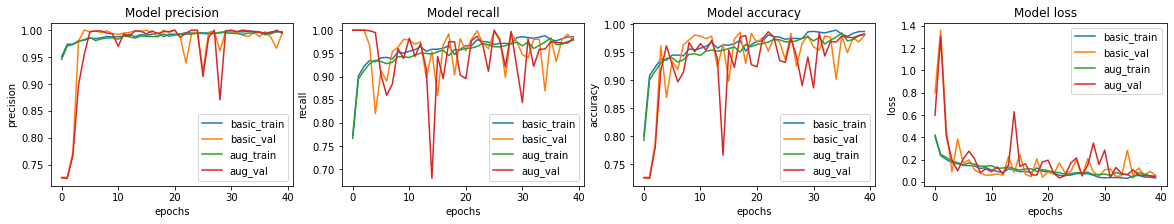

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].plot(history_aug.history[met])
    ax[i].plot(history_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['basic_train', 'basic_val', 'aug_train', 'aug_val'])

### augmentation vs no drop + augmentation

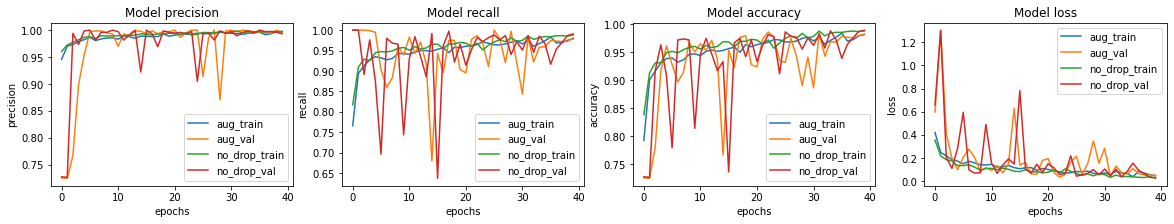

In [36]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_aug.history[met])
    ax[i].plot(history_aug.history['val_' + met])
    ax[i].plot(history_no_drop.history[met])
    ax[i].plot(history_no_drop.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['aug_train', 'aug_val','no_drop_train', 'no_drop_val'])

### no drop + augmentation vs no drop + augmentation + lr scheduler

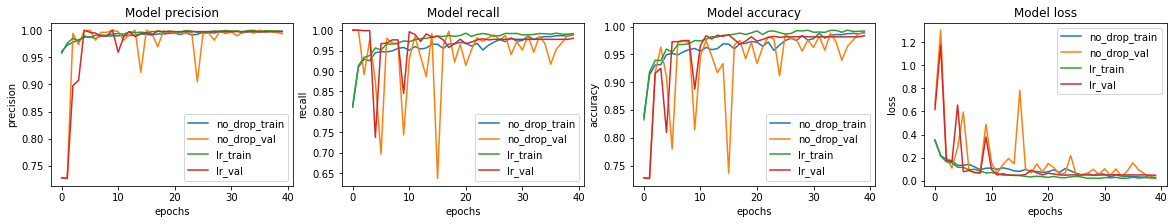

In [37]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no_drop.history[met])
    ax[i].plot(history_no_drop.history['val_' + met])
    ax[i].plot(history_no_drop_lr.history[met])
    ax[i].plot(history_no_drop_lr.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['no_drop_train', 'no_drop_val', 'lr_train', 'lr_val',])

## Report

캐글의 Chest X-Ray Images dataset을 가지고 폐렴을 진단하는 모델을 만들었습니다.  
<br>
기본 모델을 만들고 모델을 개선하기 위한 여러가지 방법을 적용해보고 결과를 비교하였습니다.
1. basic model vs basic model + data augmentation  
     기본 모델과 data augmentation을 이용한 모델을 비교하였습니다. data augmentation은 이미지를 좌우반전하여 적용하였습니다.

<br>

2. basic model vs without drop  
     기본 모델과 dropout을 제거한 모델을 비교하였습니다.

<br>

3. without drop vs without drop + learning rate scheduler  
    2.에서의 dropout을 제거한 모델과 그 모델에 learning rate scheduler를 추가한 모델을 비교하였습니다.

<br>
    
기본 모델이 0.8269로 성능이 가장 좋게 나왔습니다.
 